In [1]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, sampler
from transform import get_train_transforms, get_test_transforms, CLAHE_GRAY
from tqdm import tqdm
from model import TrafficSignNet
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import torchattacks
import torch
# To load the picked dataset


class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform

    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

# To move batches to the GPU


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43

    X_extended = np.empty([0] + list(dataset.features.shape)
                          [1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype=dataset.labels.dtype)

    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])

    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y == c], axis=0)

        if c in horizontally_flippable:
            X_extended = np.append(
                X_extended, X[y == c][:, :, ::-1, :], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(
                X_extended, X[y == c][:, ::-1, :, :], axis=0)
        if c in cross_flippable[:, 0]:
            flip_c = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(
                X_extended, X[y == flip_c][:, :, ::-1, :], axis=0)
        if c in both_flippable:
            X_extended = np.append(
                X_extended, X[y == c][:, ::-1, ::-1, :], axis=0)

        y_extended = np.append(y_extended, np.full(
            X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))

    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)

    return dataset


def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in tqdm(range(len(X)), desc=f"Processing {dataset} dataset"):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)


def get_train_loaders(path, device, batch_size, workers, class_count):
    def to_device(x, y):
        return x.to(device), y.to(device, dtype=torch.int64)

    train_dataset = extend_dataset(PickledDataset(
        path+'/train_gray.p', transform=get_train_transforms()))
    valid_dataset = PickledDataset(
        path+'/valid_gray.p', transform=get_test_transforms())

    # Use weighted sampler
    class_sample_count = np.bincount(train_dataset.labels)
    weights = 1 / np.array([class_sample_count[y]
                            for y in train_dataset.labels])
    samp = sampler.WeightedRandomSampler(weights, 43 * class_count)
    train_loader = WrappedDataLoader(DataLoader(
        train_dataset, batch_size=batch_size, sampler=samp, num_workers=workers), to_device)
    valid_loader = WrappedDataLoader(DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=workers), to_device)

    return train_loader, valid_loader


def get_test_loader(path, device, gray=True):
    def preprocess(x, y):
        return x.to(device), y.to(device, dtype=torch.int64)

    test_dataset = PickledDataset(
        path+'/test_gray.p', transform=get_test_transforms())
    test_loader = WrappedDataLoader(DataLoader(
        test_dataset, batch_size=64, shuffle=False), preprocess)

    return test_loader

def get_test_loader_adv(model_adv,path, device, gray=True,ep=0.01):
    def preprocess(x, y):
        model_ad=TrafficSignNet().to(device)
#         x=fast_gradient_method(model_ad, x, eps=0.1, norm=np.inf, clip_min=0., clip_max=1.) 
        atk = torchattacks.FGSM(model_adv, eps=ep)
#         atk = torchattacks.CW(model_adv, c=1, kappa=0, steps=20, lr=0.01)
        y=torch.tensor(y, dtype=torch.int64)
        x = atk(x, y)
        return x.to(device), y.to(device, dtype=torch.int64)

    test_dataset = PickledDataset(
        path+'/test_gray.p', transform=get_test_transforms())
    test_loader = WrappedDataLoader(DataLoader(
        test_dataset, batch_size=64, shuffle=False), preprocess)

    return test_loader


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
from torch import nn
from model import TrafficSignNet
# from data import get_test_loader,get_test_loader_adv
from torchvision.utils import make_grid
from train import valid_batch,valid_batch_Adv
from tqdm import tqdm


def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(
            *[valid_batch(model, loss_func, x, y) for x, y in tqdm(dl)])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100

        print(f"Test loss: {test_loss:.6f}\t"
              f"Test accruacy: {test_accuracy:.3f}%")

def evaluateAdv(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(
            *[valid_batch_Adv(model, loss_func, x, y) for x, y in tqdm(dl)])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100

        print(f"Test loss: {test_loss:.6f}\t"
              f"Test accruacy: {test_accuracy:.3f}%")

def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img


def visualize_stn(dl, outfile):
    with torch.no_grad():
        data = next(iter(dl))[0]

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')

        plt.savefig(outfile)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('./model_adv/modeladv_FGSM.pt', map_location=device)
checkpoint2 = torch.load('./model_benign/model.pt', map_location=device)
# Neural Network and Loss Function
model = TrafficSignNet().to(device)
model.load_state_dict(checkpoint)
model.eval()
criterion = nn.CrossEntropyLoss()

model2 = TrafficSignNet().to(device)
model2.load_state_dict(checkpoint2)
model2.eval()
criterion2 = nn.CrossEntropyLoss()
eps = [8/255,16/255,25.5/255,50/255]
losses_no=[]
accuracies_no=[]
losses_mit=[]
accuracies_mit=[]
for ep in eps:
    # Data Initialization and Loading
#     test_loader = get_test_loader('./data', device)
    test_loader_adv = get_test_loader_adv(model2, './data', device,True,ep)
    print('Evaluating Using Adv data and none-mitigating model')

    # evaluate(model2, criterion2, test_loader)

    losses, corrects, nums = zip(*[valid_batch(model2, criterion, x, y) for x, y in tqdm(test_loader_adv)])
    test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_accuracy = np.sum(corrects) / np.sum(nums) * 100
    losses_no.append(test_loss)
    accuracies_no.append(test_accuracy)
    print(f"Test loss: {test_loss:.6f}\t"
      f"Test accruacy: {test_accuracy:.3f}%")
    # visualize_stn(test_loader, args.outfile)
    print('Evaluating Using Adv data and mitigating model')

    # evaluate(model, criterion, test_loader)

    losses, corrects, nums = zip(*[valid_batch(model, criterion, x, y) for x, y in tqdm(test_loader_adv)])
    test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_accuracy = np.sum(corrects) / np.sum(nums) * 100
    losses_mit.append(test_loss)
    accuracies_mit.append(test_accuracy)
    print(f"Test loss: {test_loss:.6f}\t"
      f"Test accruacy: {test_accuracy:.3f}%")

Evaluating Using Adv data and none-mitigating model


  0%|          | 0/198 [00:00<?, ?it/s]<ipython-input-1-3719bddd2ca0>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y, dtype=torch.int64)
C:\Users\amalb\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\amalb\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\functional.py:4043: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the docume

Test loss: 0.552430	Test accruacy: 85.629%
Evaluating Using Adv data and mitigating model


100%|██████████| 198/198 [00:12<00:00, 15.57it/s]


Test loss: 0.223826	Test accruacy: 93.175%
Evaluating Using Adv data and none-mitigating model


100%|██████████| 198/198 [00:12<00:00, 15.53it/s]


Test loss: 2.343763	Test accruacy: 52.676%
Evaluating Using Adv data and mitigating model


100%|██████████| 198/198 [00:12<00:00, 15.57it/s]


Test loss: 0.526717	Test accruacy: 80.554%
Evaluating Using Adv data and none-mitigating model


100%|██████████| 198/198 [00:12<00:00, 15.67it/s]


Test loss: 4.847048	Test accruacy: 30.230%
Evaluating Using Adv data and mitigating model


100%|██████████| 198/198 [00:12<00:00, 15.61it/s]


Test loss: 1.056176	Test accruacy: 62.130%
Evaluating Using Adv data and none-mitigating model


100%|██████████| 198/198 [00:12<00:00, 15.65it/s]


Test loss: 8.237821	Test accruacy: 13.484%
Evaluating Using Adv data and mitigating model


100%|██████████| 198/198 [00:12<00:00, 15.23it/s]

Test loss: 1.972022	Test accruacy: 41.876%


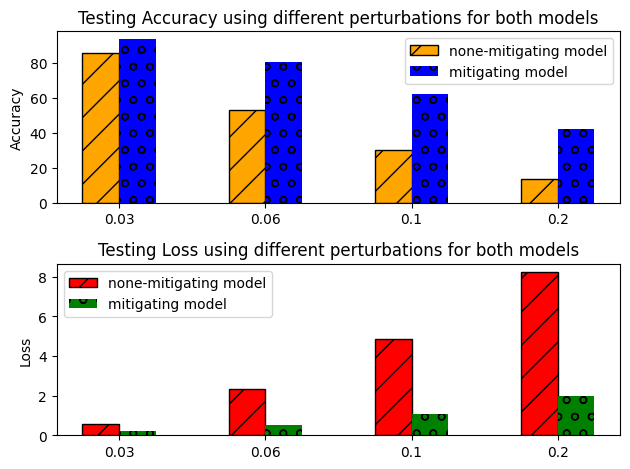

In [5]:
import matplotlib.pyplot as plt
import numpy as np


labels = [str(float("{:.2f}".format(ep))) for ep in eps]
non_mitigate_accus = [acc for acc in accuracies_no]
mitigate_accus = [acc for acc in accuracies_mit]

non_mitigate_losses = [loss for loss in losses_no]
mitigate_losses = [loss for loss in losses_mit]

x = np.arange(len(labels))  # the label locations
width = 0.25 # the width of the bars

fig, (ax1, ax2) = plt.subplots(2)
rects1 = ax1.bar(x - width/2, non_mitigate_accus, width, label='none-mitigating model',color='orange', edgecolor='black', hatch="/")
rects2 = ax1.bar(x + width/2, mitigate_accus, width, label='mitigating model', color='blue', ecolor='black',hatch='o')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Accuracy')
ax1.set_title('Testing Accuracy using different perturbations for both models')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='best')

rects1 = ax2.bar(x - width/2, non_mitigate_losses, width, label='none-mitigating model',color='red', edgecolor='black', hatch="/")
rects2 = ax2.bar(x + width/2, mitigate_losses, width, label='mitigating model', color='green', ecolor='black',hatch='o')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Loss')
ax2.set_title('Testing Loss using different perturbations for both models')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc='best')

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# ax.set_ylim(0,1)
fig.tight_layout()

plt.show()

In [7]:
def accuracy(out, y):
    '''
    Calculate accuracy of model where
    out.shape = (64, 2) and y.shape = (64)
    '''
    out = torch.max(out, 1)[1].float()
#     print('out',len(out))
    eq = torch.eq(out, y.float()).float()
    return torch.mean(eq)

In [9]:
#models=[model2, model3]
X=[]
Y=[]
test_loader = get_test_loader('./data', device)
count=0
for data, target in test_loader:
    count+=1
    X.append(data.to(device))
    Y.append(target.to(device))
    X_test= data.to(device)
    X.append(X_test)
    Y_test = target.to(device)
    Y.append(Y_test)

In [55]:
import torch.nn.functional as F
outall_adv_m1=[]
accu_adv_m1=[]
lenX=7
# model=models[4]
top_p1_adv, top_class1_adv  = [],[]
for i in range(lenX):
    model.eval()
    X_test = X[i].to(device)
    X_test = fast_gradient_method(model, X_test, eps=0.01, norm=np.inf) 
#     delta = pgd(model, X_test, Y[i], 0.1, 1e4, 100)
#     out= model(X_test+delta) 
    out= model(X_test) 
    #     print('model',i)
    #     print(F.softmax(out, dim=1))
    prob = F.softmax(out, dim=1)
    outall_adv_m1.append(prob)
    top_p1_adv_temp, top_class1_adv_temp = prob.topk(1, dim = 1)
    top_p1_adv.append(top_p1_adv_temp)
    top_class1_adv.append(top_class1_adv_temp)
    accu_adv_m1.append(accuracy(out, Y[i]).cpu().data.numpy())

In [56]:
outall_adv_m3=[]
accu_adv_m3=[]
# model=models[2]
top_p3_adv, top_class3_adv  = [],[]
for i in range(lenX):
    model2.eval()
    X_test = X[i]
    X_test = fast_gradient_method(model2, X_test, eps=0.3, norm=np.inf)
#     delta = pgd(model, X_test, Y[i], 0.1, 1e4, 100)
#     out= model(X_test+delta) 
    out= model2(X_test) 
    #     print('model',i)
    #     print(F.softmax(out, dim=1))
    prob = F.softmax(out, dim=1)
    outall_adv_m3.append(prob)
    top_p3_adv_temp, top_class3_adv_temp = prob.topk(1, dim = 1)
    top_p3_adv.append(top_p3_adv_temp)
    top_class3_adv.append(top_class3_adv_temp)
    accu_adv_m3.append(accuracy(out, Y[i]).cpu().data.numpy())

In [57]:
outall_m1=[]
accu_m1=[]
# model=models[4]
top_p1, top_class1  = [],[]
for i in range(lenX):
    model.eval()
    X_test = X[i]
#     X_test = fast_gradient_method(model, X_test, eps=0.03, norm=np.inf)                
    out= model(X_test) 
    #     print('model',i)
    #     print(F.softmax(out, dim=1))
    prob = F.softmax(out, dim=1)
    outall_m1.append(prob)
    top_p1_temp, top_class1_temp = prob.topk(1, dim = 1)
    top_p1.append(top_p1_temp)
    top_class1.append(top_class1_temp)
    accu_m1.append(accuracy(out, Y[i]).cpu().data.numpy())

In [58]:
outall_m3=[]
accu_m3=[]
# model=models[2]
top_p3, top_class3  = [],[]
for i in range(lenX):
    model2.eval()
    X_test = X[i]
#     X_test = fast_gradient_method(model, X_test, eps=0.03, norm=np.inf)                
    out= model2(X_test) 
    #     print('model',i)
    #     print(F.softmax(out, dim=1))
    prob= F.softmax(out, dim=1)
    outall_m3.append(prob)
    top_p3_temp, top_class3_temp = prob.topk(1, dim = 1)
    top_p3.append(top_p3_temp)
    top_class3.append(top_class3_temp)
    accu_m3.append(accuracy(out, Y[i]).cpu().data.numpy())

In [59]:
divall1=[]
divall2=[]
for j in range(lenX):
    for i in range(len(outall_adv_m1[j])):
#         Adv_count2_attack.append(1)
        divall1.append(kl_divergence(outall_adv_m1[j][i],outall_adv_m3[j][i]).detach().cpu().numpy())
        divall2.append(kl_divergence(outall_m3[j][i],outall_m1[j][i]).detach().cpu().numpy())

396


In [60]:
from math import log2
 
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
 

0.6914624612740131
col_0   0.000005  0.000005  0.000008  0.000018  0.000021  0.000041  0.000041  \
row_0                                                                          
counts         2         2         2         2         1         1         1   

col_0   0.000051  0.000061  0.000079  ...  0.455173  0.464312  0.521442  \
row_0                                 ...                                 
counts         1         1         1  ...         2         2         2   

col_0   0.794890  1.073648  1.220396  1.685471  2.928273  3.337128  3.798805  
row_0                                                                         
counts         1         2         2         2         2         2         2  

[1 rows x 256 columns]
Mean=12.940, Standard Deviation=6.722
Mean=0.104, Standard Deviation=0.420
Min sample1 0.03421705216169357,max sample1 30.20583724975586 ,min sample2 4.815502506971825e-06, max sample2 0.7948898673057556


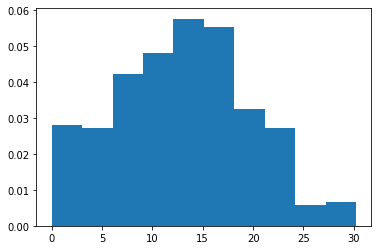

In [61]:
# example of parametric probability density estimation
import matplotlib.pyplot as plt
from numpy.random import normal
from numpy import mean
from numpy import std
from scipy.stats import norm
from scipy import stats
import numpy as np
import pandas as pd
# generate a sample
sample =np.array(divall1)
sample2 =np.array(divall2)

# calculate parameters
sample_mean = mean(sample)
sample_std = std(sample)
sample_mean2 = mean(sample2)
sample_std2 = std(sample2)

# pd.DataFrame(sample).plot(kind="density",figsize = (9,9))
# pd.DataFrame(sample2).plot(kind="density",figsize = (9,9))
print(stats.norm.cdf(x=0.5))
print(pd.crosstab(index="counts",columns = sample2))

an_array = np.array([1, 4, 1, 1, 2, 1, 3])
mean = np.mean(an_array)
# standard_deviation = np.std(an_array)
distance_from_mean = abs(sample2 - sample_mean2)
max_deviations = 2

not_outlier = distance_from_mean < max_deviations * sample_std2
sample2 = sample2[not_outlier]

print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean2, sample_std2))
print(f'Min sample1 {min(sample)},max sample1 {max(sample)} ,min sample2 {min(sample2)}, max sample2 {max(sample2)}')
# define the distribution
dist = norm(sample_mean, sample_std)
dist2= norm(sample_mean2, sample_std2)
# sample probabilities for a range of outcomes
values = [value for value in range(round(min(sample)), round(max(sample)))]
values2 = [value for value in range(round(min(sample2)),round(max(sample2)))]

probabilities = [dist.pdf(value) for value in values]
probabilities2 = [dist.pdf(value) for value in values2]

# plot the histogram and pdf
plt.hist(sample, bins=10, density=True)
# plt.hist(sample2, bins=10, density=True)

# plt.plot(values, probabilities,color= 'r')
plt.plot(values2, probabilities2)

plt.show()

In [62]:
p=np.zeros(7)
for i in range(7):
    p[i] = np.percentile(sample2, 100-(5*(i+1))) 

print(np.flip(p))

[0.01402376 0.02025693 0.03008326 0.05049043 0.07530778 0.14629233
 0.24466606]


In [63]:
Thresholds_ = np.flip(p)

In [65]:
# Adverserial Input:
count=0
div1_attack=[]
div2_attack=[]
adv=0
no_adv=0
adv_all_attack=[]
no_adv_all_attack=[]
Adv_count2_attackin=[]
no_adv_all_attackin=[]

num_sucess_attack = []
num_nosucess_attack = []
num_detected_attack = []
num_nodetected_attack = []

for k,Thresh in enumerate(Thresholds_):
    Adv_count2_attack=[]
    div_count2_attack = []
#     num_sucess_attack_t = []
#     num_nosucess_attack_t = []
#     num_detected_attack_t = []
    adv=0
    no_adv=0
    success_attack = 0
    no_success_attack = 0
    success_detected_attck = 0
    success_nodetected_attck = 0
    False_alarm = 0
    True_alarm = 0
    for j in range(lenX):
        for i in range(len(outall_adv_m1[j])):
            Adv_count2_attack.append(1)
            dif1=kl_divergence(outall_adv_m1[j][i],outall_adv_m3[j][i])
            dif2=kl_divergence(outall_adv_m3[j][i],outall_adv_m1[j][i])
            dif2_compare = kl_divergence(outall_m3[j][i],outall_m1[j][i])
#             print('dif1=',dif1,'dif2 = ',dif2)
            div1_attack.append(dif1.detach().item())
            div2_attack.append(dif2.detach().item())
#             print('top_class1_adv[j][i] , top_class3_adv[j][i]  , Y[j][i]',top_class1_adv[j][i] , Y[j][i],top_class3_adv[j][i])
            if top_class1_adv[j][i] == Y[j][i] == top_class3_adv[j][i] and dif2.item() > Thresh:
                no_success_attack=no_success_attack + 1
                success_detected_attck  = success_detected_attck+ 1 
                False_alarm = False_alarm+1
            
            if top_class1_adv[j][i] == Y[j][i] == top_class3_adv[j][i] and dif2.item() < Thresh:
                no_success_attack = no_success_attack + 1
                success_nodetected_attck  = success_nodetected_attck+ 1     
                
            if top_class1_adv[j][i]  == top_class3_adv[j][i]  != Y[j][i] and dif2.item() > Thresh:
                True_alarm = True_alarm + 1
                success_attack = success_attack+1
                success_detected_attck  = success_detected_attck+ 1 
            
            if top_class1_adv[j][i]  == top_class3_adv[j][i]  != Y[j][i] and dif2.item() < Thresh:
                success_attack = success_attack+1
                success_nodetected_attck  = success_nodetected_attck+ 1     
                
            if top_class1_adv[j][i]  == Y[j][i] != top_class3_adv[j][i] and dif2.item() > Thresh:
                False_alarm = False_alarm+1
                success_detected_attck  = success_detected_attck+ 1 
                no_success_attack=no_success_attack + 1
            
            if top_class3_adv[j][i]  == Y[j][i] != top_class1_adv[j][i] and dif2.item() > Thresh:
                True_alarm = True_alarm + 1
                success_detected_attck  = success_detected_attck+ 1 
                no_success_attack=no_success_attack + 1    
            
            if top_class1_adv[j][i]  == Y[j][i] != top_class3_adv[j][i] and dif2.item() < Thresh:
#                 success_attack = success_attack+1
                success_nodetected_attck  = success_nodetected_attck+ 1 
                no_success_attack=no_success_attack + 1

#             print('Success',success_attack, 'No-sucess',no_success_attack,'success_detected_attck',success_detected_attck,'dif2.item()',dif2.item(),'dif2_compare',dif2_compare.item())    
   
            if dif2.item() >Thresh:
                div_count2_attack.append(1)
                adv+=1
            else:
                div_count2_attack.append(0)
                no_adv+=1  
    print('False_alarm',False_alarm,'True_alarm',True_alarm)
    num_sucess_attack.append(success_attack)
    num_nosucess_attack.append(no_success_attack)
    num_detected_attack.append(success_detected_attck)   
    num_nodetected_attack.append(success_nodetected_attck) 
    adv_all_attack.append(adv)
    no_adv_all_attack.append(no_adv)
    Adv_count2_attackin.append(Adv_count2_attack)
    no_adv_all_attackin.append(div_count2_attack)
print('Number of adverserial Samples is:',no_adv+adv,'no divergence', no_adv,'divergence', adv)  

False_alarm 435 True_alarm 0
False_alarm 435 True_alarm 0
False_alarm 435 True_alarm 0
False_alarm 434 True_alarm 0
False_alarm 434 True_alarm 0
False_alarm 434 True_alarm 0
False_alarm 433 True_alarm 0
Number of adverserial Samples is: 448 no divergence 4 divergence 444


In [66]:
sum(div1_attack)

40580.0174889192

In [67]:
sum(div2_attack)

37473.04503071029

In [69]:
# benign Input:
count=0
div1_noattack=[]
div2_noattack=[]
adv=0
no_adv=0
adv_all_noattack=[]
no_adv_all_noattack=[]
Adv_count2_noattackin=[]
no_adv_all_noattackin=[]
# Thresholds_ = [0.5,1,1.5,2,3,4,5]
for k, Thresh in enumerate(Thresholds_):
    Adv_count2_noattack=[]
    div_count2_noattack = []
    adv=0
    no_adv=0
    for j in range(lenX):
        for i in range(len(outall_adv_m1[j])):
            Adv_count2_noattack.append(0)
            dif1=kl_divergence(outall_m1[j][i],outall_m3[j][i])
            dif2=kl_divergence(outall_m3[j][i],outall_m1[j][i])
            div1_noattack.append(dif1.detach().item())
#             print('dif1=',dif1,'dif2 = ',dif2)
            div2_noattack.append(dif2.detach().item())
            if dif2.item() > Thresh:
                div_count2_noattack.append(1)
                adv+=1
            else:
                div_count2_noattack.append(0)
                no_adv+=1
    adv_all_noattack.append(adv)
    no_adv_all_noattack.append(no_adv)
    Adv_count2_noattackin.append(Adv_count2_noattack)
    no_adv_all_noattackin.append(div_count2_noattack)
print('Number of adverserial Samples is:',no_adv+adv,'no divergence', no_adv,'divergence', adv)  

Number of adverserial Samples is: 448 no divergence 414 divergence 34


In [70]:
sum(div1_noattack)

1671.752454056259

In [71]:
sum(div2_noattack)

327.10579115583187

Confusion matrix, without normalization
[[284 164]
 [  2 446]]
Confusion matrix, without normalization
[[305 143]
 [  2 446]]
Confusion matrix, without normalization
[[328 120]
 [  2 446]]
Confusion matrix, without normalization
[[350  98]
 [  3 445]]
Confusion matrix, without normalization
[[370  78]
 [  3 445]]
Confusion matrix, without normalization
[[393  55]
 [  3 445]]
Confusion matrix, without normalization
[[414  34]
 [  4 444]]


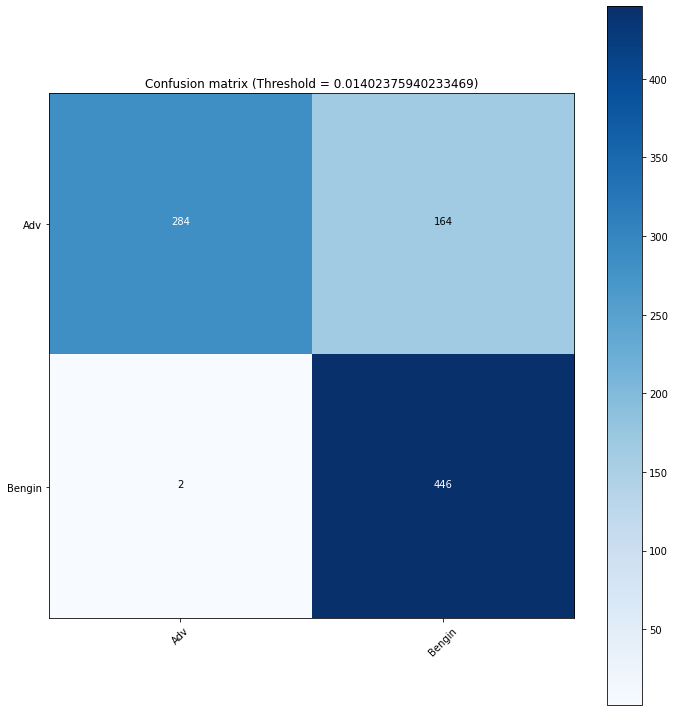

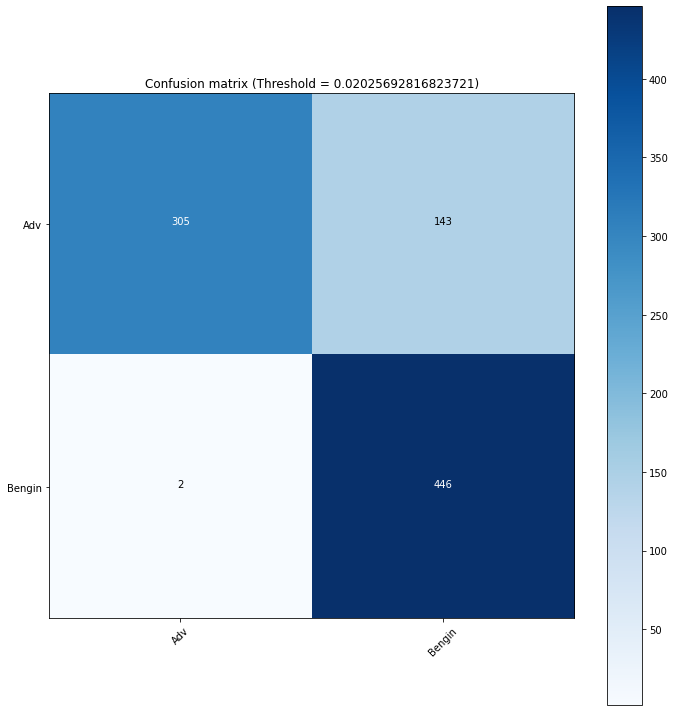

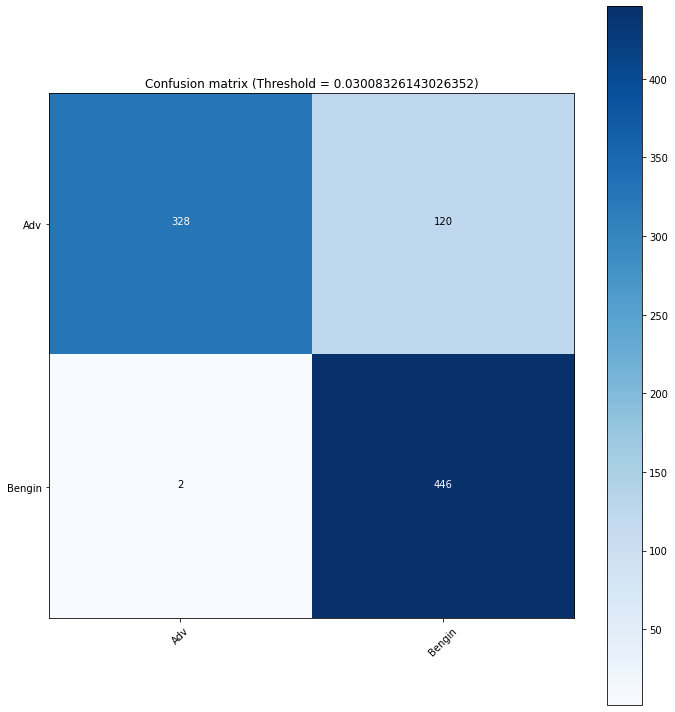

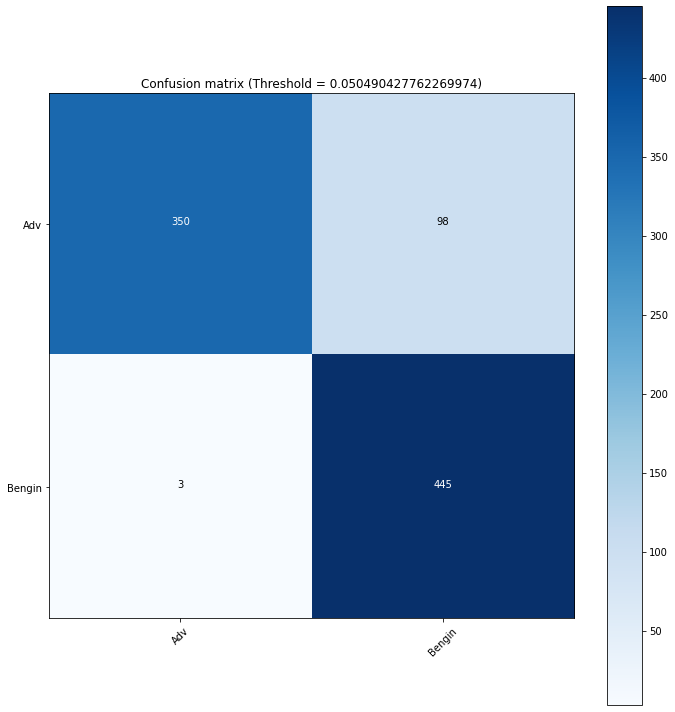

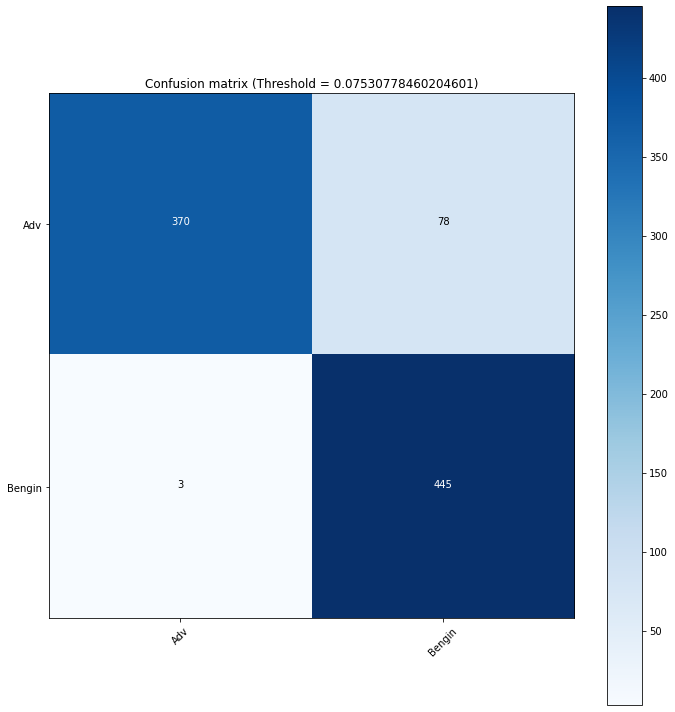

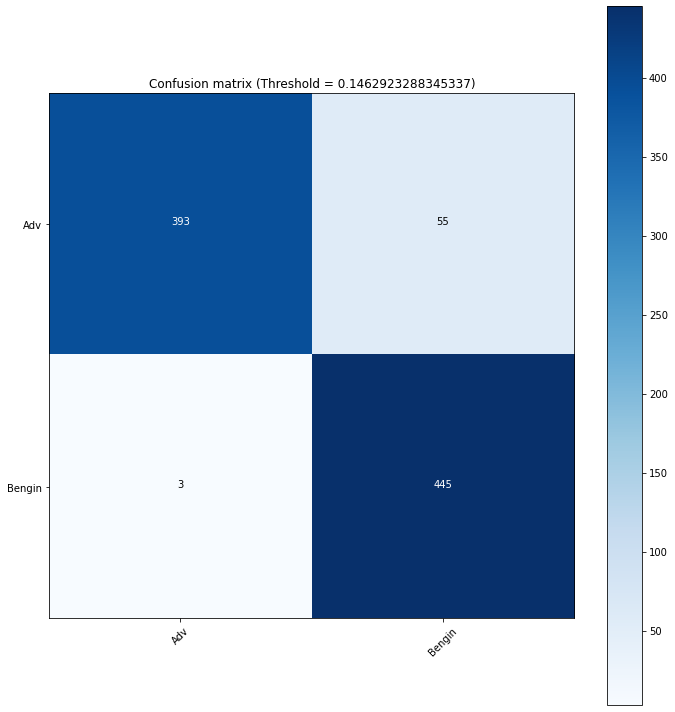

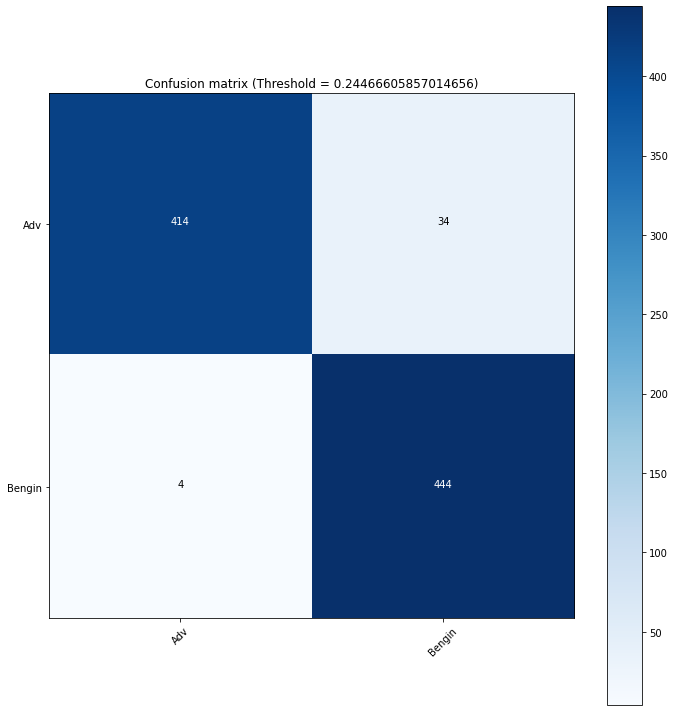

In [81]:
from sklearn.metrics import confusion_matrix
for j, Thresh in enumerate(Thresholds_):    
        Adv_countall = Adv_count2_noattackin[j]+Adv_count2_attackin[j]
        div_countall = no_adv_all_noattackin[j] + no_adv_all_attackin[j]
        cm = confusion_matrix(Adv_countall,div_countall)
        plot_cm(cm, title='Confusion matrix (Threshold = '+str(Thresh)+')',save_title= 'Confusion_matrix_Threshold_CW'+str(Thresh)+'.pdf')

In [80]:
def plot_cm(cm, title='Confusion matrix', save_title='untiteled'):
    plt.figure(figsize=(10,10))
    names=['Adv','Bengin']
    plot_confusion_matrix(cm, names,title=title,save_title=save_title)

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',save_title='untitled', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('')
    plt.xlabel('')  
    plt.savefig('./figures/Confusion-matrix/'+save_title)
